In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lit

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/12 15:53:11 WARN Utils: Your hostname, DESKTOP-LNDD2A2 resolves to a loopback address: 127.0.1.1; using 172.21.140.219 instead (on interface eth0)
22/10/12 15:53:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/12 15:53:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/12 15:53:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/12 15:53:15 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Ranking System

Ranking System uses the following features:
- future predictions for transactions per merchant per month
- future predictions for profit per merchant per month
- future predictions for customers within revenue range \\$50k-\\$75k per month
- population (quartiles) of young adults and middle aged adults based on postcodes of consumers

In [2]:
future_trans_sdf = spark.read.parquet("../data/curated/futuretrans.parquet/")
future_trans_sdf.limit(5)

year,month,merchant_abn,total_transactions
2023,4,51026003250,31.04763929559019
2023,4,59248738261,33.48164050911184
2023,4,22298599094,37.406815900936635
2023,4,83004629651,32.18754728743305
2023,4,10385163239,30.385875300308964


In [3]:
future_profit_sdf = spark.read.parquet("../data/curated/futureprofit.parquet/")
future_profit_sdf.limit(5)

year,month,merchant_abn,total_profit
2023,4,51026003250,330.0064557418861
2023,4,59248738261,926.9256077916019
2023,4,22298599094,268.7838578500479
2023,4,83004629651,244.74317960336447
2023,4,10385163239,323.1332842674351


In [4]:
future_mcustomers_sdf = spark.read.parquet("../data/curated/futuremcustomers.parquet/")
future_mcustomers_sdf.limit(5)

year,month,merchant_abn,total_middle_customers
2023,7,36066395091,64.94303414454085
2023,7,87998844202,79.45028034832727
2023,7,66842618444,75.74034755604113
2023,7,46145508777,13.899866466213558
2023,7,80508375382,83.68346812191125


In [5]:
merch_pop = spark.read.parquet("../data/curated/merch_pop.parquet/")
merch_pop.limit(5)

merchant_abn,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop
10255988167,2,2,3,2,2,4
10264435225,2,2,2,1,2,3
10430380319,3,3,3,3,3,3
10441711491,3,3,2,3,2,3
10462560289,4,4,4,4,4,4


In [6]:
merchants_pd = future_trans_sdf \
    .select('merchant_abn') \
    .distinct() \
    .withColumn('points', lit(1)) \
    .orderBy("merchant_abn") \
    .toPandas()

merchants_pd

,merchant_abn,points
0,10023283211,1
1,10142254217,1
2,10165489824,1
3,10187291046,1
4,10192359162,1
...,...,...
4013,99938978285,1
4014,99974311662,1
4015,99976658299,1
4016,99987905597,1


Have 4018 distinct merchants, need to select top 100 merchants

Idea:
- all merchants have initial points 1
- the more the number of points, the higher/better the rank will be
- points given based on sorted positioning within the features and importance of the feature (for transaction, profit, and mcustomers)

In [7]:
WEIGHT_TRANS = 0.375
WEIGHT_PROFIT = 0.375
WEIGHT_MCUSTOMERS = 0.125
WEIGHT_POP = 0.125

***

Award 0.125 points to merchants having a relatively large young adult and middle age population (external research) <br>
with large meaning the populations are above the lower quartile (not group 1 - see notebook 4.4)

In [8]:
w = Window.partitionBy('month')

merch_pop_mod = merch_pop \
    .drop(*("total_pop", "under10_pop", "adolsc_pop", "old_pop")) \
    .withColumn(
        "points",
        when(
            (col("yng_adult_pop") != 1) &
            (col("mid_age_pop") != 1),
            lit(0.125)
        ).otherwise(lit(0))
    ) \
    .drop(*("yng_adult_pop", "mid_age_pop")) \
    .orderBy("merchant_abn")

merch_pop_mod.limit(10)

merchant_abn,points
10023283211,0.0
10142254217,0.0
10165489824,0.125
10187291046,0.125
10192359162,0.125
10206519221,0.0
10255988167,0.125
10264435225,0.0
10279061213,0.0
10323485998,0.125


In [9]:
merch_pop_mod_df = merch_pop_mod.toPandas()
merch_pop_mod_df

,merchant_abn,points
0,10023283211,0.000
1,10142254217,0.000
2,10165489824,0.125
3,10187291046,0.125
4,10192359162,0.125
...,...,...
4013,99938978285,0.000
4014,99974311662,0.000
4015,99976658299,0.125
4016,99987905597,0.125


In [10]:
merchants_pd

,merchant_abn,points
0,10023283211,1
1,10142254217,1
2,10165489824,1
3,10187291046,1
4,10192359162,1
...,...,...
4013,99938978285,1
4014,99974311662,1
4015,99976658299,1
4016,99987905597,1


In [11]:
merchants_pd["points"] = merchants_pd["points"] + merch_pop_mod_df["points"]
merchants_pd

,merchant_abn,points
0,10023283211,1.000
1,10142254217,1.000
2,10165489824,1.125
3,10187291046,1.125
4,10192359162,1.125
...,...,...
4013,99938978285,1.000
4014,99974311662,1.000
4015,99976658299,1.125
4016,99987905597,1.125


***

Get the merchant with the highest number of total transactions for each month (`ft_agg2`):

In [12]:
w = Window.partitionBy('month')

ft_agg2 = future_trans_sdf \
    .withColumn('maxT', F.max('total_transactions').over(w)) \
    .where(F.col('total_transactions') == F.col('maxT')) \
    .drop('maxT')

ft_agg2

year,month,merchant_abn,total_transactions
2023,1,24852446429,12706.867430622047
2023,2,24852446429,12725.976797500647
2023,3,24852446429,12601.879475370839
2023,4,24852446429,12624.618672374758
2023,5,24852446429,12557.475159081536
2023,6,24852446429,12576.861500222918
2023,7,24852446429,12540.356167994907
2023,8,24852446429,12555.113743323984
2023,9,24852446429,12535.352343858927
2023,10,24852446429,12546.091227819079


__[reference for above code](https://stackoverflow.com/questions/48829993/groupby-column-and-filter-rows-with-maximum-value-in-pyspark)__



For each month, order the merchants by increasing order of their total transactions <br>
(merchant with lowest number of transactions for that month will be at the top)

In [13]:
ordered_ft_pd = future_trans_sdf \
    .orderBy(asc("month"), asc("total_transactions")) \
    .drop("year") \
    .toPandas()

ordered_ft_pd

,month,merchant_abn,total_transactions
0,1,62346852889,21.097950
1,1,35235320738,21.149586
2,1,86791380020,21.154814
3,1,34455283435,21.199792
4,1,98082781436,21.204058
...,...,...,...
48211,12,46804135891,10163.244846
48212,12,49891706470,10724.271327
48213,12,64203420245,11311.885569
48214,12,86578477987,11805.480411


Note for below that `groupby` preserves ordering within each group

In [14]:
merch_abns = list(merchants_pd["merchant_abn"])

MONTHS = 12
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_ft_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more transactions the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_TRANS*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merchants_pd["points"] = merchants_pd["points"] + new_points


In [15]:
merchants_pd

,merchant_abn,points
0,10023283211,14680.750
1,10142254217,14446.000
2,10165489824,184.125
3,10187291046,8435.625
4,10192359162,8808.000
...,...,...
4013,99938978285,17421.250
4014,99974311662,5447.875
4015,99976658299,17627.625
4016,99987905597,6729.750


***

Get the merchant with the highest profit for each month (`fp_agg2`):

In [16]:
w = Window.partitionBy('month')

fp_agg2 = future_profit_sdf \
    .withColumn('maxP', F.max('total_profit').over(w)) \
    .where(F.col('total_profit') == F.col('maxP')) \
    .drop('maxP')

fp_agg2

year,month,merchant_abn,total_profit
2023,1,32361057556,27740.570878728235
2023,2,32361057556,27878.7679430336
2023,3,32361057556,27552.75259841377
2023,4,32361057556,27653.557096675115
2023,5,32361057556,27479.095309639102
2023,6,32361057556,27551.766701347373
2023,7,32361057556,27461.515288951385
2023,8,32361057556,27514.536693437625
2023,9,32361057556,27471.280954645557
2023,10,32361057556,27511.178900430907


For each month, order the merchants by increasing order of their total profit <br>
(merchant with lowest total profit for that month at the top)

In [17]:
ordered_fp_pd = future_profit_sdf \
    .orderBy(asc("month"), asc("total_profit")) \
    .drop("year") \
    .toPandas()

ordered_fp_pd

,month,merchant_abn,total_profit
0,1,16156289887,169.090896
1,1,86791380020,177.765852
2,1,33068332703,179.699605
3,1,10441711491,179.786133
4,1,21350600012,179.972700
...,...,...,...
48211,12,96680767841,25475.481580
48212,12,45629217853,25860.368887
48213,12,86578477987,27096.311961
48214,12,48534649627,27268.520005


In [18]:
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_fp_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more profit the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_PROFIT*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merchants_pd["points"] = merchants_pd["points"] + new_points

In [19]:
merchants_pd

,merchant_abn,points
0,10023283211,18909.250
1,10142254217,23638.000
2,10165489824,3668.250
3,10187291046,12815.250
4,10192359162,20447.250
...,...,...
4013,99938978285,31240.375
4014,99974311662,8866.000
4015,99976658299,35401.875
4016,99987905597,15740.250


***

Get the merchant with the highest number of middle customers for each month (`fmc_agg2`):

In [20]:
w = Window.partitionBy('month')

fmc_agg2 = future_mcustomers_sdf \
    .withColumn('maxMC', F.max('total_middle_customers').over(w)) \
    .where(F.col('total_middle_customers') == F.col('maxMC')) \
    .drop('maxMC')

fmc_agg2

year,month,merchant_abn,total_middle_customers
2023,1,24852446429,2796.8587999146635
2023,2,24852446429,2794.892202393302
2023,3,24852446429,2781.9611881292603
2023,4,24852446429,2781.828716128044
2023,5,24852446429,2775.997045578518
2023,6,24852446429,2776.425821608259
2023,7,24852446429,2773.9088483222054
2023,8,24852446429,2774.4608952929357
2023,9,24852446429,2773.4974495653432
2023,10,24852446429,2774.0415413334777


For each month, order the merchants by increasing order of their total predicted population of middle income earning customers <br>

In [21]:
ordered_fmc_pd = future_mcustomers_sdf \
    .orderBy(asc("month"), asc("total_middle_customers")) \
    .drop("year") \
    .toPandas()

ordered_fmc_pd

,month,merchant_abn,total_middle_customers
0,1,28836033916,4.850240
1,1,14626521979,4.850240
2,1,37706925794,4.850240
3,1,95594775419,4.850240
4,1,37670671283,4.850240
...,...,...,...
48211,12,46804135891,2379.631110
48212,12,49891706470,2465.908543
48213,12,64203420245,2576.013135
48214,12,86578477987,2670.840636


In [22]:
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_fmc_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more profit the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_MCUSTOMERS*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merchants_pd["points"] = merchants_pd["points"] + new_points

In [23]:
merchants_pd

,merchant_abn,points
0,10023283211,23850.625
1,10142254217,28458.250
2,10165489824,3773.875
3,10187291046,15534.750
4,10192359162,23528.500
...,...,...
4013,99938978285,37048.125
4014,99974311662,10775.875
4015,99976658299,41278.625
4016,99987905597,17827.500


In [24]:
spark.createDataFrame(merchants_pd).write.mode("overwrite").parquet("../data/curated/rankings.parquet")

***

Get the top 100 merchants

In [25]:
merchants_sdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
merchants_sdf.limit(5)

company_name,tags,merchant_abn,take_rate,revenue_band
Felis Limited,"furniture, home f...",10023283211,0.18,e
Arcu Ac Orci Corp...,"cable, satellite,...",10142254217,4.22,b
Nunc Sed Company,"jewelry, watch, c...",10165489824,4.40,b
Ultricies Digniss...,"watch, clock, and...",10187291046,3.29,b
Enim Condimentum PC,music shops - mus...,10192359162,6.33,a


In [26]:
rankings = spark.createDataFrame(merchants_pd.iloc[1:101,]).sort(desc("points"))
rankings

merchant_abn,points
11439466003,41540.125
10648956813,40908.5
11237511112,40857.75
11121775571,40188.75
10323485998,39819.0
11566786699,38848.875
11944993446,38710.875
12173100693,38597.375
11285988014,36616.25
11841065357,36444.75


In [27]:
merchants_sdf = merchants_sdf.join(rankings, "merchant_abn").orderBy(desc("points"))
merchants_sdf

merchant_abn,company_name,tags,take_rate,revenue_band,points
11439466003,Blandit At LLC,shoe shops,5.71,a,41540.125
10648956813,Proin Nisl Institute,"computers, comput...",6.66,a,40908.5
11237511112,Magna Institute,"opticians, optica...",2.11,c,40857.75
11121775571,Egestas Nunc Asso...,digital goods: bo...,6.58,a,40188.75
10323485998,Nunc Inc.,"furniture, home f...",6.61,a,39819.0
11566786699,Euismod Et Institute,"opticians, optica...",2.62,c,38848.875
11944993446,Tincidunt Dui Corp.,"gift, card, novel...",6.60,a,38710.875
12173100693,Quam Quis Diam Fo...,"gift, card, novel...",5.65,a,38597.375
11285988014,Tincidunt Pede Co...,digital goods: bo...,6.30,a,36616.25
11841065357,Eu Tellus Industries,motor vehicle sup...,4.42,b,36444.75


Text(0.5, 0, 'Frequency')

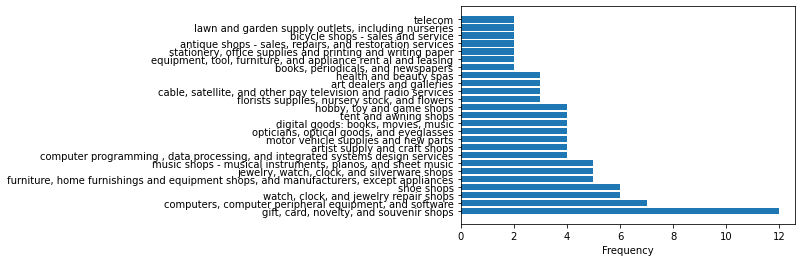

In [28]:
tags_count = merchants_sdf.groupBy("tags") \
    .agg(
        count("merchant_abn").alias("count")
    ) \
    .orderBy(desc("count")) \
    .toPandas()

plt.barh(tags_count["tags"], tags_count["count"])
plt.xlabel("Frequency")

([<matplotlib.patches.Wedge at 0x7fc20ce926a0>,
 [Text(0.23995754141400957, 1.0735084435245696, ' a'),
  Text(-0.8899186574910393, -0.6465638275138399, ' b'),
  Text(0.7778174957174648, -0.7778174228929381, ' c'),
  Text(1.0978294029847897, -0.06906954424390042, ' d')],
 [Text(0.13088593168036883, 0.5855500601043107, '43.00'),
  Text(-0.48541017681329407, -0.3526711786439127, '34.00'),
  Text(0.4242640885731626, -0.42426404885069346, '21.00'),
  Text(0.5988160379917035, -0.03767429686030931, '2.00')])

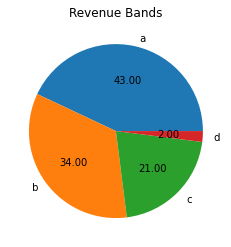

In [29]:
rev_band_count = merchants_sdf.groupBy("revenue_band") \
    .agg(
        count("merchant_abn").alias("count")
    ) \
    .orderBy(desc("count")) \
    .toPandas()

plt.title("Revenue Bands")
plt.pie(rev_band_count["count"], autopct='%.2f', labels=rev_band_count["revenue_band"])
